In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
# For better readability later on, we do some imports and definitions here
import acoular as ac
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio


def show_signal(signal):
    plt.figure(1,(10,3))
    plt.psd(signal, 
            Fs = f_sample,
            NFFT = 4096)
    plt.show()

    # Play the sound
    display(Audio(signal, rate = f_sample))
    
def plot_setup(mics, traj):
    plt.figure(2,(10,3))

    # plot observer
    plt.plot(mics.pos[0,:], mics.pos[1,:], 'rx', label = 'observer')

    # plot trajectory
    times = np.linspace(0,11,100)
    xt, yt, zt = traj.location(times)
    plt.plot(xt, yt, label = 'trajectory')

    # plot the predefined waypoints
    xwp, ywp, zwp = zip(*traj.points.values())
    plt.plot(xwp, ywp, '>', label = 'traj. waypoints')

    plt.xlabel('$x$ / m')
    plt.ylabel('$y$ / m')
    plt.legend()
    plt.axis('equal')
    plt.show()

    
def show_result(data):
    signal = ac.tools.return_result(data)
    plt.figure(3,(10,5))
    plt.specgram(signal[:,0], 
                 Fs = f_sample,
                 noverlap = 4096-256,
                 NFFT = 4096,
                 vmin=-100,
                 vmax=-50)
    plt.ylim(0,5000)
    plt.colorbar()
    plt.xlabel('$t$ / s')
    plt.ylabel('$f$ / Hz')
    plt.show()
    
    # Play the sound
    display(Audio(signal.T, rate = f_sample))

<img src="img/DAGA_logo.png" alt="DAGA Logo" style="width:160px; position:absolute; top:20px; right:20px;">
<img src="img/TU-lang.png" alt="TU Logo" style="width:230px; position:absolute; top:0px; right:180px;">

<h1 style="margin-top: 130px; margin-bottom: 50px; color: #A81D1E;">Acoular Workshop: Generating Synthetic Sound Pressure Time Datasets of Multicopter Drone Fly-bys</h1>
<h3 style="margin-top: 50px; margin-bottom: 70px; color: #434343;">Gert Herold, Mikolaj Czuchaj, Adam Kujawski, Oliver Lylloff, Art J. R. Pelling, Ennes Sarradj</h2>


<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    1
</div>
    
## Content 

- implementing an Acoular-compatible class for generating an artificial multicopter signal
- setting up a virtual flight path in 3D space
- simulation of a moving dipole source
- exporting HDF and WAV files for flyby auralization

<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    2
</div>

## Measurement example

![measured_spectrogram](img/spectro_23-04-04_13-12-03_874736_8192_15sg.png)
<audio src="wav/measurement_drone.wav" controls>Der verwendete Browser unterstützt das Audio-Format nicht.</audio>

<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    3
</div>

## Implementing a new class `<Developer mode ON>`

In [3]:
# import traits.api to enforce data types in object parameters
from traits.api import List, Int, Property

class DroneSignalGenerator( ac.NoiseGenerator ):
    """
    Class for generating a synthetic multicopter drone signal. 
    This is just a basic example class for demonstration purposes 
    with only few settable and some arbitrary fixed parameters.
    It is not intended to create perfectly realistic signals.
    """

    # List with rotor speeds (for each rotor independently)
    # Default: 1 rotor, 15000 rpm
    rpm_list = List([15000,])

    # Number of blades per rotor
    # Default: 2
    num_blades_per_rotor = Int(2)
    
    # internal identifier
    digest = Property(depends_on=['rpm_list', 'num_blades_per_rotor', 
                                  'rms', 'seed',
                                  'sample_freq', 'num_samples'])

    def _get_digest(self):
        return ac.internal.digest(self)

    def signal( self ):
        """
        function that returns the full signal
        """
        # initialize a random generator for noise generation
        rng = np.random.default_rng(seed = self.seed)
        # use 1/f² broadband noise as basis for the signal
        wn = rng.standard_normal(self.num_samples) # normal distributed values
        wnf = np.fft.rfft(wn) # transform to freq domain
        wnf /= (np.linspace(0.1,1,len(wnf))*5)**2 # spectrum ~ 1/f²
        sig = np.fft.irfft(wnf) # transform to time domain

        # vector with all time instances
        t = np.arange(self.num_samples, dtype=float) / self.sample_freq

        # iterate over all rotors
        for rpm in self.rpm_list:
            f_base = rpm / 60 # rotor speed in Hz

            # randomly set phase of rotor
            phase = rng.uniform() * 2*np.pi
            
            # calculate higher harmonics up to 50 times the rotor speed
            for n in np.arange(50)+1:
                # if we're looking at a blade passing frequency, make it louder
                if n % self.num_blades_per_rotor == 0:
                    amp = 1
                else:
                    amp = 0.2

                # exponentially decrease amplitude for higher freqs with arbitrary factor
                amp *= np.exp(-n/10)
                
                # add harmonic signal component to existing signal
                sig += amp * np.sin(2*np.pi*n * f_base * t + phase) 

        # return signal normalized to given RMS value
        return sig * self.rms / np.std(sig)

<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    4
</div>

## `<Developer mode OFF>` – Use the new class!

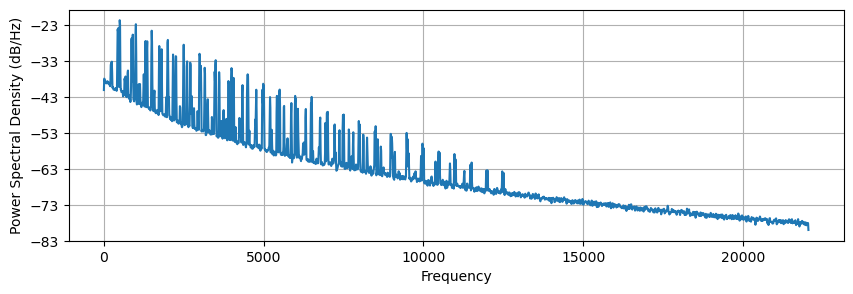

In [4]:
# length of signal
t_msm = 10.5 # s
# sampling frequency
f_sample = 44100 # Hz

drone_signal = DroneSignalGenerator(rpm_list = [15010, 14962, 13536, 13007], 
                                    num_blades_per_rotor = 2, 
                                    sample_freq = f_sample, 
                                    num_samples = f_sample * t_msm)

show_signal(drone_signal.signal())

<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    5
</div>

## Microphones & Trajectory

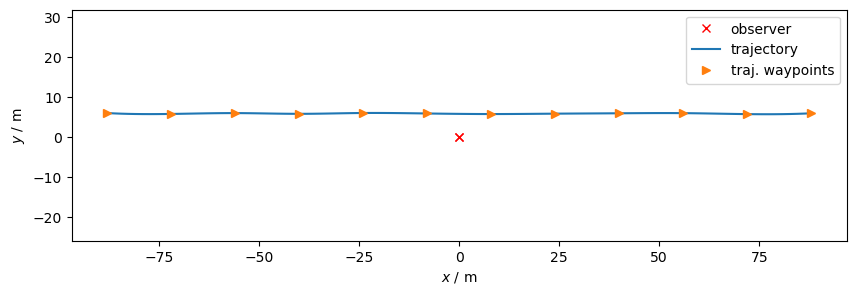

In [5]:
# Define the array geometry
two_microphones = ac.MicGeom()
two_microphones.pos_total = np.array([[-0.07, 0.07], # x positions, all values in m
                                      [-0.03, 0.03], # y
                                      [ 1.7 , 1.7]]) # z
    

# Define the trajectory
flight_speed = 16 # m/s

# 11 seconds trajectory, which is a little more than we have signal for
ts = np.arange(12) 

# initialize a random generator for path deviations
rng = np.random.default_rng(seed = 23)

# Set one waypoint each second, 
waypoints = { t : ((t-5.5)*flight_speed,       # vary 
                     6 + rng.uniform(-0.2,0.2), # randomly vary y position up to ±0.2 m around 6 m 
                    10 + rng.uniform(-0.3,0.3)) # randomly vary z position up to ±0.3 m around 10 m height
              for t in ts }

traj = ac.Trajectory(points = waypoints)

# show setup

plot_setup(two_microphones, traj)


<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    6
</div>

## Medium & source properties

In [6]:
# We'll keep the environment simple for now: just air at standard conditions with speed of sound 343 m/s
e = ac.Environment(c=343.)

# Define point source
p = ac.MovingPointSourceDipole(signal = drone_signal, # the signal of the source
                               trajectory = traj,     # set trajectory
                               conv_amp = True,       # take into account convective amplification
                               mics = two_microphones,# set the "array" with which to measure the sound field
                               start = 0.5,           # observation starts 0.5 seconds after signal starts at drone
                               env = e)               # the environment the source is moving in

<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    7
</div>

## A simple way to include the ground

In [7]:
# Copy the waypoints from the original source into a new trajectory, but with inverted z
waypoints_reflection = { time : (x, y, -z) for time, (x, y, z) in waypoints.items() }
traj_reflection = ac.Trajectory(points = waypoints_reflection)

# Define a mirror source with the mirrored trajectory
p_reflection = ac.MovingPointSourceDipole(signal = drone_signal,        # the same signal as above
                                          trajectory = traj_reflection, # set trajectory of mirror source
                                          conv_amp = True,
                                          mics = two_microphones,
                                          start = 0.5,
                                          env = e) 

# Mix the original source and the mirror source
drone_above_ground = ac.SourceMixer( sources = [p, p_reflection] )

<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    8
</div>

## Run the simulation & save the output!

-- here block diagram with all contributing objects --

[('void_cache.h5', 1)]


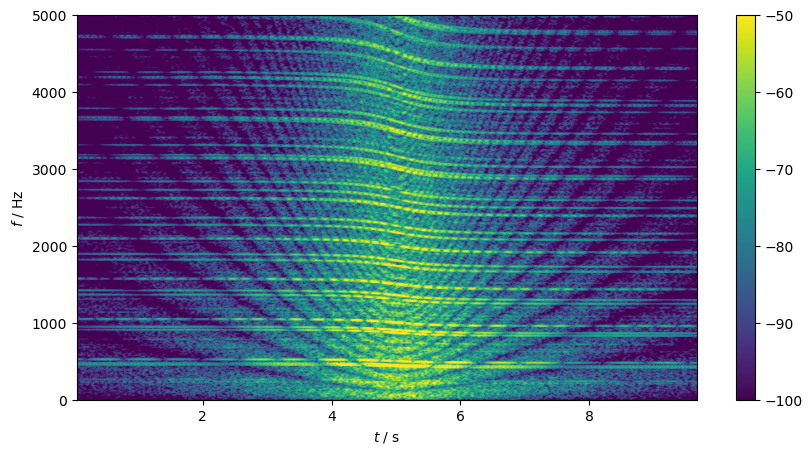

In [8]:
# Write data stream onto disk for later re-use. This step is not necessary if runtime isn't an issue.
cached_signals = ac.Cache(source = drone_above_ground)

# Prepare wav output.
# If you don't need caching, you can directly put "source = drone_above_ground" here.
output = ac.WriteWAV(file = 'drone_flyby_with_ground_reflection.wav',
                     source = cached_signals, 
                     channels = [0,1]) # export both channels as stereo

# Start the actual export
output.save()

# plot the signal
show_result(cached_signals)

<div style="width: 20px; font-size: 10px; float: right; text-align:right" > 
    9
</div>

## Conclusion

...